In [1]:
import pennylane as qml
from pennylane import numpy as np
from IPython.display import display, Latex

# from numba import jit

# numpy 
import numpy as np_
import scipy as sp

import random

import matplotlib.pyplot as plt

# 2-qubit
dev = qml.device('default.mixed', wires = 2)

# == Hamiltonian setup == 
coeffs = [1]
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]

hamiltonian = qml.Hamiltonian(coeffs, obs)

In [2]:
# == Global paras ==
Tau_global = 5e-2
Paras_global, Phi_global, Gamma_ps  = np_.array([0] * 3), 0, 0

# Return one by one
def Dephase_factor(tau):
    Calculate_Dephase = 1 - np.exp(-2 * tau)
    
    return Calculate_Dephase

$$
\rho_{After-Hadamard} = 

\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}$$

$$

where,
\quad \gamma = 
1 - e^{-2 \tau}
$$


$$ 
e^{-\tau} = \sqrt{1 - \gamma}
$$

In [3]:

# == Generate circuit ==

# circuit_1
@qml.qnode(dev)
def circuit_1(paras):
    # Call global phi
    global Phi_global, Tau_global
    phi = Phi_global
    
    # Assign paras
    theta_init, tau_1, tau_2 = paras[0], paras[1], paras[2]
    
    # Calculate dephase factor with fixed tau
    gamma_dephase_in = Dephase_factor(Tau_global)
    # print(gamma_dephase_in, Dephase_global)
        
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(hamiltonian, tau_1, 1)
    # qml.PhaseDamping(gamma_dephase_in, wires = 0)
    # qml.PhaseDamping(gamma_dephase_in, wires = 1)
    
    qml.RX(theta_init, wires = 0)    
    qml.RX(theta_init, wires = 1)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(hamiltonian, tau_2, 1)
    # qml.PhaseDamping(gamma_dephase_in, wires = 0)
    # qml.PhaseDamping(gamma_dephase_in, wires = 1)

    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    
    # Stage_3: Accumulater
    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    qml.PhaseDamping(gamma_dephase_in, wires = 0)
    qml.PhaseDamping(gamma_dephase_in, wires = 1)
    
    qml.RY(-np.pi/2, wires=0)
    qml.RY(-np.pi/2, wires=1)
    
    return qml.density_matrix(wires=[0, 1])


# Circuit_2: Calculate decoherence by using [tau -> gamma_dephase_in] conversion
@qml.qnode(dev)
def Post_selection_Dephase(phi):
    
    # theta_init, tau_1, tau_2, gamma_1, gamma_2, gamma_3 = paras[0], paras[1], paras[2], paras[3], paras[4], paras[5]
    global Paras_global, Phi_global, Gamma_ps
    Phi_global = phi
    
    # Get density matrix from circuit_1
    density_matrix = circuit_1(Paras_global)
    qml.QubitDensityMatrix(density_matrix, wires=[0, 1])
    
    # Kraus operator for 2*2 matrix
    K = np.array([ [np.sqrt(1 - Gamma_ps), 0], [0, 1] ])
    K_H = K.conj().T
    
    Numerator = sp.linalg.kron(K, K) @ density_matrix @ sp.linalg.kron(K_H, K_H)
    Denominator = np.trace(sp.linalg.kron(K, K) @ density_matrix @ sp.linalg.kron(K_H, K_H))
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires=[0, 1])
    
    return qml.density_matrix(wires=[0, 1])  

$$ K =  \begin{bmatrix}
\sqrt{1-\gamma} & 0 \\
0 & 1 
\end{bmatrix}  $$


$$
\rho_{ps} = 
\frac{(K \otimes K) \rho (K^{\dagger} \otimes K ^{\dagger})}

{Tr[(K \otimes K) \rho (K^{\dagger} \otimes K ^{\dagger})]}
$$

![Alt text](image-1.png)

In [4]:
# == Cost function ==
def Cost_function(paras):
    # expect: theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3 = paras[0], paras[1], paras[2], paras[3], paras[4], paras[5]
    global Paras_global, Phi_global
    Paras_global, phi = paras, np.array([Phi_global])
          
    CFI = qml.qinfo.classical_fisher(Post_selection_Dephase)(phi[0])
    
    return -CFI

In [5]:
# == Check for maximum tau <-> gamma ==
tau_test = 5e-2

print('Gamma =', Dephase_factor(tau_test), ', [ at tau =',tau_test,']' )

Gamma = 0.09516258196404048 , [ at tau = 0.05 ]


In [6]:
# == BFGS -> Return Data_set:[phi, CFI, 6-Paras] ==
def BFGS(Sweep_Data, paras, gamma_ps_select, Iterations):
    # Create Data array
    PHI = np_.arange(Sweep_Data[0], Sweep_Data[1], Sweep_Data[2]).reshape(-1, 1)
    Data = np_.zeros((Iterations + 1, len(PHI), len(paras) + 2)) 
    
    Data[:, :, 0] = PHI.squeeze() # Append PHI in to 0th col
    
    # Set Data index
    CFI_INDEX, PARAS_INDEX, BEFORE_OPT_LAYER_INDEX = 1, 2, 0
    
    # Set global variables
    global Gamma_ps, Phi_global, Paras_global
    Gamma_ps = gamma_ps_select 
    
    # Declare Paras temp 
    Paras_Temporary = 0
    
    for Phi_Index in range(len(PHI)):
        Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][CFI_INDEX] = -Cost_function(paras)
        
    for Layer_Index in range(1, Iterations + 1):
        for Phi_Index in range(len(PHI)):
            # Load previous paras
            Paras_Temporary = paras if Layer_Index == 1 else Data[Layer_Index][Phi_Index][PARAS_INDEX:]
            
            # Set Phi(Currently sweeping)
            Phi_global = Data[Layer_Index][Phi_Index][0]
            
            # Constraints(gamma = 0.99..) 
            tau_upper = 18
            Constraints = [(-float('inf'), float('inf'))] * 3 
            
            # Push paras to global var
            Paras_global = Paras_Temporary
            Result_BFGS = sp.optimize.minimize(Cost_function, Paras_Temporary, method = 'SLSQP', bounds = Constraints)
            Data[Layer_Index][Phi_Index][CFI_INDEX] = -Result_BFGS.fun
            
            # Store data in array
            for Paras_Index_Array in range(len(Paras_Temporary)):
                Data[Layer_Index][Phi_Index][PARAS_INDEX + Paras_Index_Array] = Result_BFGS.x[Paras_Index_Array]
            
    return Data

Data = 

array([ [PHI_0, CFI_0, theta_0, tau_1, tau_2, tau_d1, tau_d2, tau_d3], 

...

In [7]:
# == Fixed to gamma_ps = 0.8 ==

# == Sweep for 0 ~ pi*3 == 
Step = np.pi/25     #1e-1
Sweep_data = np_.array([1e-4, np.pi * 6 + 1e-4, Step])

Para_init = np_.zeros(3)
Para_init[:3] = random.uniform(0, 1)

Gamma_ps_preset = 0.8
Set_Iterations = 3

Optimized_Result = BFGS(Sweep_data, Para_init, Gamma_ps_preset, Set_Iterations)

In [8]:
# Optimized_Result[:, 0]

# layer = 0 & test_case = 3.01000000e-01
Current_Layer = 1
Optimized_Result[Current_Layer][:, 0:2]

# Optimized_Result[0][:,:]

array([[1.00000000e-04, 5.82983971e+01],
       [1.25763706e-01, 5.82983971e+01],
       [2.51427412e-01, 5.82983966e+01],
       [3.77091118e-01, 5.82983969e+01],
       [5.02754825e-01, 5.82983970e+01],
       [6.28418531e-01, 5.82983970e+01],
       [7.54082237e-01, 5.82983971e+01],
       [8.79745943e-01, 5.82983971e+01],
       [1.00540965e+00, 5.82983971e+01],
       [1.13107336e+00, 5.82983971e+01],
       [1.25673706e+00, 5.82983970e+01],
       [1.38240077e+00, 5.82983965e+01],
       [1.50806447e+00, 5.82978586e+01],
       [1.63372818e+00, 5.82983970e+01],
       [1.75939189e+00, 5.82983970e+01],
       [1.88505559e+00, 5.82983971e+01],
       [2.01071930e+00, 5.82983969e+01],
       [2.13638300e+00, 5.82983971e+01],
       [2.26204671e+00, 5.82983971e+01],
       [2.38771042e+00, 5.82983970e+01],
       [2.51337412e+00, 5.82983971e+01],
       [2.63903783e+00, 5.82983968e+01],
       [2.76470154e+00, 5.82983970e+01],
       [2.89036524e+00, 5.82983971e+01],
       [3.016028

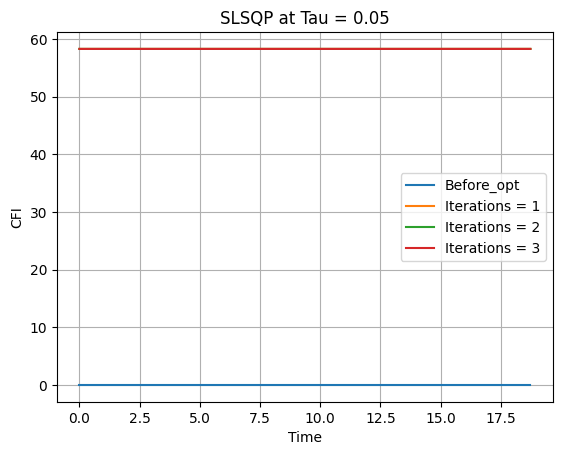

In [9]:
plt.plot(Optimized_Result[0, : ,0], Optimized_Result[0, : ,1], label = 'Before_opt')
for i in range(1, Set_Iterations + 1):
    plt.plot(Optimized_Result[0, :, 0], Optimized_Result[i, :, 1], label = f'Iterations = {i}')
    
plt.title(f'SLSQP at Tau = {Tau_global}')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid() 

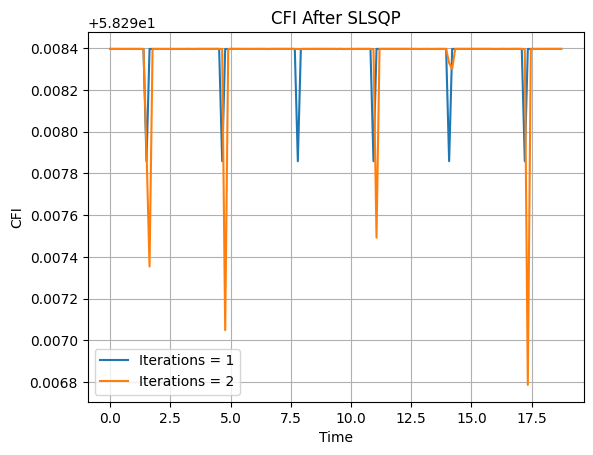

In [10]:
Target_Layer = 1, 2
plt.plot(Optimized_Result[Target_Layer[0], :, 0], Optimized_Result[Target_Layer[0], :, 1], label = f'Iterations = {Target_Layer[0]}')
plt.plot(Optimized_Result[Target_Layer[1], :, 0], Optimized_Result[Target_Layer[1], :, 1], label = f'Iterations = {Target_Layer[1]}')

plt.title('CFI After SLSQP')
plt.xlabel('Time')
plt.ylabel('CFI')

plt.legend()
plt.grid() 

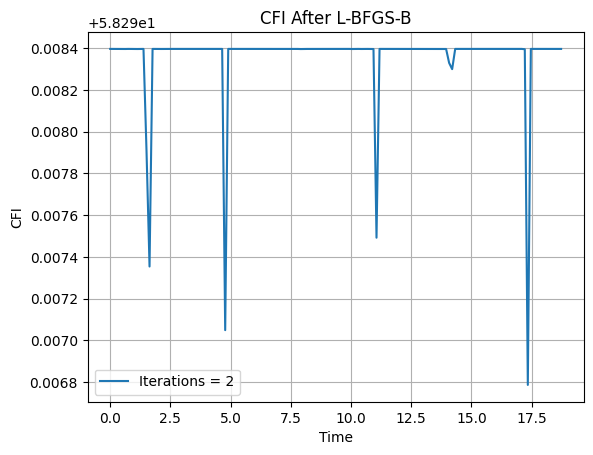

In [11]:
plt.plot(Optimized_Result[1, :, 0], Optimized_Result[Target_Layer[1], :, 1], label = f'Iterations = {Target_Layer[1]}')

plt.title('CFI After L-BFGS-B')
plt.xlabel('Time')
plt.ylabel('CFI')

plt.legend()
plt.grid() 

In [12]:
# == Check if optimized results are smaller than the past ==

Flag, Index, Count = 0, np_.zeros(len(Optimized_Result[0, :, 1])), 0
for i in range(len(Optimized_Result[2, :, 1])):
    Flag = 0 if Optimized_Result[3, i, 1] > Optimized_Result[1, i, 1]  else 1
    if Flag == 1:
        
        Index[Count] = i
        print(i)
        Count = Count+1

for i in range(len(Index)):
    print(Optimized_Result[1, int(Index[i]), 1], '  ', Optimized_Result[3, int(Index[i]), 1])

0
1
4
5
6
7
8
9
13
15
17
18
20
25
26
30
31
32
33
35
38
40
42
44
45
46
49
50
51
54
55
57
58
59
60
61
63
64
65
66
67
70
73
79
80
81
82
83
85
86
88
89
90
92
95
99
100
103
106
107
111
113
114
115
117
120
123
125
126
130
132
133
134
135
138
140
142
144
145
149
58.29839708206358    58.29839708097872
58.29839708181688    58.298396953998804
58.29839704274521    58.298397042140294
58.29839703304414    58.29839675625487
58.298397072725336    58.29839706667526
58.29839708075293    58.29839677515996
58.29839707590649    58.298397008749916
58.29839708196948    58.29839664152604
58.2983970390555    58.297353663690046
58.29839707785483    58.298396866753436
58.29839708178062    58.29839680367614
58.29839705055169    58.29839697937807
58.298397082033034    58.29839704589227
58.29839708191916    58.29839705280101
58.29839708177694    58.29839702259044
58.29839703403836    58.29839675136014
58.29839668571309    58.298396610485035
58.29839708079714    58.298397079716196
58.29839707590649    58.2983970087

Each row of 6-paras => Corresponds to phi

func(phi, paras, gamma_ps)
=> Implement on SLSQP 

Data = [[phi, CFI, theata_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3] ... N]

In [13]:
# Bad case after optimization
# 

Num_of_Layer = 1
Condition = np_.where(Optimized_Result[Num_of_Layer][:, 1] < 98)

print('Index:\n', Condition[0])

print('\n')

Optimized_Result[Num_of_Layer, Condition[0], 1]

print('PHI:\n', Optimized_Result[Num_of_Layer, Condition[0], 0], '\n\nCFI\n', Optimized_Result[Num_of_Layer, Condition[0], 1], '\n\nParas\n', Optimized_Result[Num_of_Layer, Condition[0], 2:])

Index:
 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]


PHI:
 [1.00000000e-04 1.25763706e-01 2.51427412e-01 3.77091118e-01
 5.02754825e-01 6.28418531e-01 7.54082237e-01 8.79745943e-01
 1.00540965e+00 1.13107336e+00 1.25673706e+00 1.38240077e+00
 1.50806447e+00 1.63372818e+00 1.75939189e+00 1.88505559e+00
 2.01071930e+00 2.13638300e+00 2.26204671e+00 2.38771042e+00
 2.51337412e+00 2.63903783e+00 2.76470154e+00 2.89036524e+00
 3.01602